In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy as copy
from scipy import optimize
import torch

import sys
sys.path.append('../')  #for savo import
sys.path.append('../../machineIO/')  #for machineIO import
from savo import savo
from savo.optim import adam
from machineIO.util import plot_2D_projection, dictClass
from machineIO.objFunc import SingleTaskObjectiveFunction
from machineIO.VM import VirtualMachineIO
from machineIO import Evaluator

import botorch.settings as settings
settings.debug = True

Failed to import 'epics'
Failed to import 'phantasy'


In [3]:
ndim = 2
budget = 300
ninit = 25  # number of initial ES steps to collect data for surrogate model training
noise = 1e-2
max_dx = 2e-2
lr = 0.2

In [4]:
control_CSETs = [f'X{i}:I_CSET' for i in range(ndim)]
control_RDs   = [f'X{i}:I_RD'   for i in range(ndim)]
control_min   = -np.ones(ndim)
control_max   =  np.ones(ndim)
control_maxstep = max_dx*np.ones(ndim)
control_tols  = 1e-3*(control_max-control_min)
monitor_RDs   = ['quadratic']
control_init = 0.9*np.ones(ndim)
# monitor_min   = -np.ones(1)
# monitor_max   =  np.ones(1)
objective_PVs = monitor_RDs

In [5]:
def quadratic(x, noise=0.0):
    x = torch.as_tensor(x)
    d = x.shape[-1]
    y = torch.sum(x**2, dim=-1) / d
    return 1 - y + torch.randn_like(y) * noise

In [6]:
vmio = VirtualMachineIO(
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    monitor_RDs = monitor_RDs,
    control_min = control_min,
    control_max = control_max,
    # monitor_min = monitor_min,
    # monitor_max = monitor_max,
    fetch_data_time_span = 1.0,
    fun = quadratic,
)

In [7]:
vmio.x = control_init
ret, df = vmio.get_df(monitor_RDs)

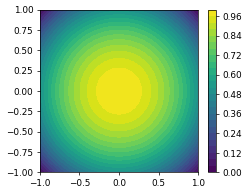

In [8]:
grid = np.linspace(-1,1,128)
x1,x2 = np.meshgrid(grid,grid)
xgrid = np.vstack((x1.flatten(), x2.flatten())).T
ygrid = quadratic(xgrid,noise=0)
def plot_contour(figsize=(4,3.3),dpi=128):
    fig,ax = plt.subplots(figsize=figsize,dpi=dpi)
    cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=32)
    fig.colorbar(cs,ax=ax)
    return fig,ax
fig,ax = plot_contour(dpi=64)

In [9]:
obj_func = SingleTaskObjectiveFunction(
    objective_PVs = monitor_RDs,
    composite_objective_name = monitor_RDs,
    objective_goal = {'quadratic':{'more than':0.8}},
    objective_weight = {'quadratic':1},
    objective_tolerance = {'quadratic':0.2},
    # custom_function = rastrigin,
)

In [10]:
evaluator = Evaluator(
    machineIO = vmio,
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    control_tols = control_tols,
    monitor_RDs = monitor_RDs,
    # df_manipulators = [obj_func.calculate_objectives_from_df],
)

# ES

In [11]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, 'quadratic', evaluator,# optimizer=optimizer,
         obj_func_noise=0.1)
for i in range(budget):
    sv.step(lr=0,lrES=1)
history = evaluator.get_history()['mean']

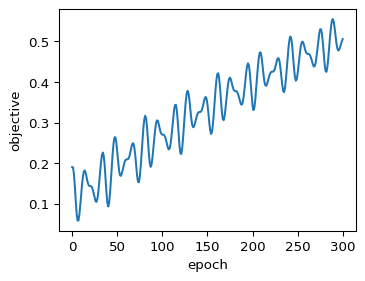

In [12]:
fig, ax = plt.subplots(figsize=(4,3),dpi=96)
# history['rastrigin'].plot(ax=ax)
xaxis = np.arange(len(history))
ax.plot(xaxis, history['quadratic'])
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

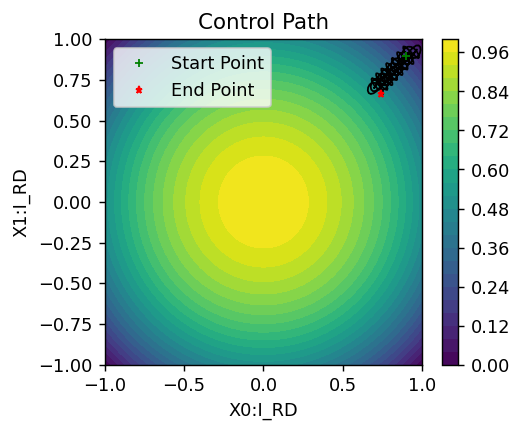

In [13]:
fig, ax = plot_contour()
ax.plot(history['X0:I_RD'],history['X1:I_RD'],'k',lw=1)
start_x = history['X0:I_RD'][0]
start_y = history['X1:I_RD'][0]
end_x = history['X0:I_RD'][-1]
end_y = history['X1:I_RD'][-1]
ax.plot(start_x, start_y, 'g+', markersize=4, label='Start Point') # 'go' for green circle
ax.plot(end_x, end_y, 'r*', markersize=4, label='End Point') # 'rs' for red square
ax.set_xlabel('X0:I_RD')
ax.set_ylabel('X1:I_RD')
ax.set_title('Control Path')
ax.legend() # Show the labels
plt.show()

# ES + adamSG

In [14]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, 'quadratic', evaluator, optimizer=optimizer,
         obj_func_noise=0.1)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1)
history = evaluator.get_history()['mean']

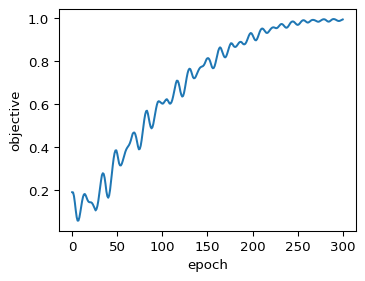

In [15]:
fig, ax = plt.subplots(figsize=(4,3),dpi=96)
# history['rastrigin'].plot(ax=ax)
xaxis = np.arange(len(history))
ax.plot(xaxis, history['quadratic'])
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

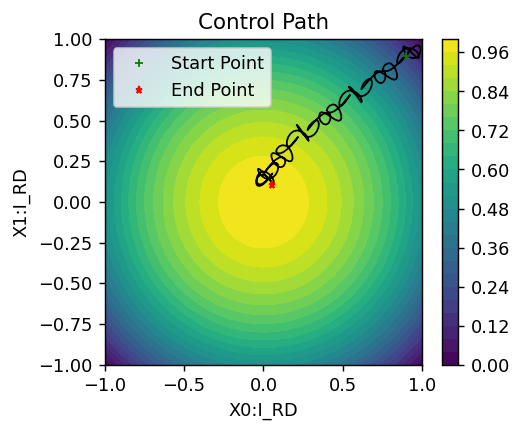

In [16]:
fig, ax = plot_contour()
ax.plot(history['X0:I_RD'],history['X1:I_RD'],'k',lw=1)
start_x = history['X0:I_RD'][0]
start_y = history['X1:I_RD'][0]
end_x = history['X0:I_RD'][-1]
end_y = history['X1:I_RD'][-1]
ax.plot(start_x, start_y, 'g+', markersize=4, label='Start Point') # 'go' for green circle
ax.plot(end_x, end_y, 'r*', markersize=4, label='End Point') # 'rs' for red square
ax.set_xlabel('X0:I_RD')
ax.set_ylabel('X1:I_RD')
ax.set_title('Control Path')
ax.legend() # Show the labels
plt.show()

# ES + SG

In [17]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, 'quadratic', evaluator,# optimizer=optimizer,
         obj_func_noise=0.1)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1)
history = evaluator.get_history()['mean']

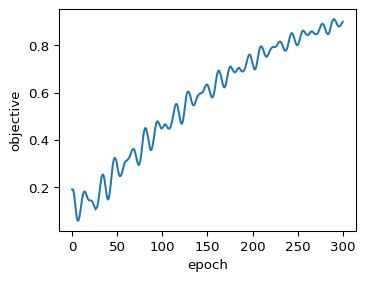

In [18]:
fig, ax = plt.subplots(figsize=(4,3),dpi=96)
# history['rastrigin'].plot(ax=ax)
xaxis = np.arange(len(history))
ax.plot(xaxis, history['quadratic'])
ax.set_xlabel('epoch');
ax.set_ylabel('objective');

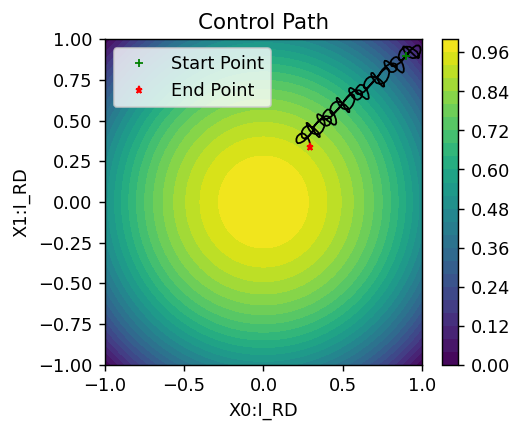

In [19]:
fig, ax = plot_contour()
ax.plot(history['X0:I_RD'],history['X1:I_RD'],'k',lw=1)
start_x = history['X0:I_RD'][0]
start_y = history['X1:I_RD'][0]
end_x = history['X0:I_RD'][-1]
end_y = history['X1:I_RD'][-1]
ax.plot(start_x, start_y, 'g+', markersize=4, label='Start Point') # 'go' for green circle
ax.plot(end_x, end_y, 'r*', markersize=4, label='End Point') # 'rs' for red square
ax.set_xlabel('X0:I_RD')
ax.set_ylabel('X1:I_RD')
ax.set_title('Control Path')
ax.legend() # Show the labels
plt.show()